# Import necessary dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import model_evaluation_utils as meu
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# Load and Merge datasets

In [2]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

red_wine['wine_type'] = 'red'   # add a column for the type
white_wine['wine_type'] = 'white'
wines = pd.concat([red_wine, white_wine])
wines['quality_label'] = wines['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <= 7 else 'high')
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
wines.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.17         0.74            12.8      0.045   
1            7.7              0.64         0.21             2.2      0.077   
2            6.8              0.39         0.34             7.4      0.020   
3            6.3              0.28         0.47            11.2      0.040   
4            7.4              0.35         0.20            13.9      0.054   
5            7.2              0.53         0.14             2.1      0.064   
6            7.5              0.27         0.31            17.7      0.051   
7            6.8              0.11         0.27             8.6      0.044   
8            9.0              0.44         0.49             2.4      0.078   
9            7.1              0.23         0.30             2.6      0.034   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 24.0                 126.0  0.99420  3.26       0.38   
1                 32.0                 133.0  0.99560  3.27       0.45   
2                 38.0                 133.0  0.99212  3.18       0.44   
3                 61.0                 183.0  0.99592  3.12       0.51   
4                 63.0                 229.0  0.99888  3.11       0.50   
5                 15.0                  29.0  0.99323  3.35       0.61   
6                 33.0                 173.0  0.99900  3.09       0.64   
7                 45.0                 104.0  0.99454  3.20       0.37   
8                 26.0                 121.0  0.99780  3.23       0.58   
9                 62.0                 148.0  0.99121  3.03       0.56   

   alcohol  quality wine_type quality_label  
0     12.2        8     white          high  
1      9.9        5       red           low  
2     12.0        7     white        medium  
3      9.5        6     white        medium  
4      8.9        6     white        medium  
5     12.1        6       red        medium  
6     10.2        5     white           low  
7      9.9        6     white        medium  
8      9.2        5       red           low  
9     11.3        7     white        medium

# Predicting Wine Types

## Prepare Training and Testing datasets

In [4]:
wtp_features = wines.iloc[:,:-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines['wine_type'])

wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(wtp_features, wtp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print('Features:', list(wtp_feature_names))

Counter({'white': 3418, 'red': 1129}) Counter({'white': 1480, 'red': 470})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [5]:
print(wtp_train_X.shape)
print(wtp_test_X.shape)

(4547, 11)
(1950, 11)


## Feature Scaling

In [6]:
# Define the scaler 
wtp_ss = StandardScaler().fit(wtp_train_X)

# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)

# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

## Train a Model using Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

wtp_lr = LogisticRegression()
wtp_lr.fit(wtp_train_SX, wtp_train_y)

LogisticRegression()

## Predict and Evaluate Model Performance

In [8]:
wtp_lr_predictions = wtp_lr.predict(wtp_test_SX)
#meu.display_model_performance_metrics(true_labels=wtp_test_y, predicted_labels=wtp_lr_predictions, classes=['red', 'white'])

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [10]:
conf_matrix = confusion_matrix(wtp_test_y, wtp_lr_predictions)
conf_matrix

array([[ 463,    7],
       [   7, 1473]])

In [11]:
accuracy = accuracy_score(wtp_test_y, wtp_lr_predictions)
accuracy

0.9928205128205129

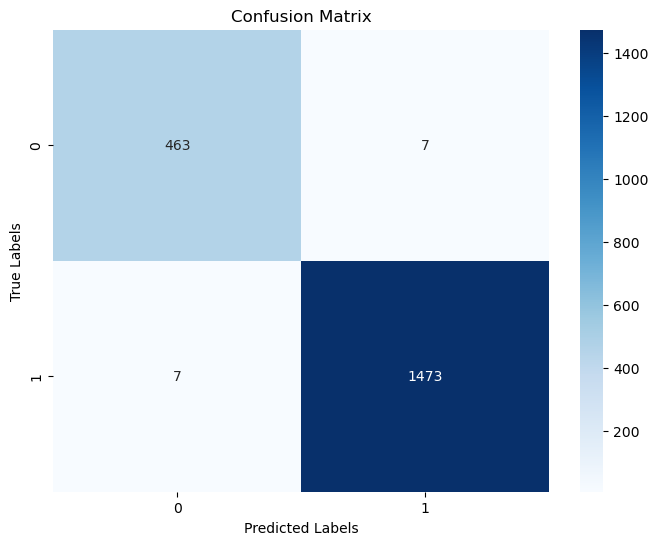

In [12]:
import seaborn as sns

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

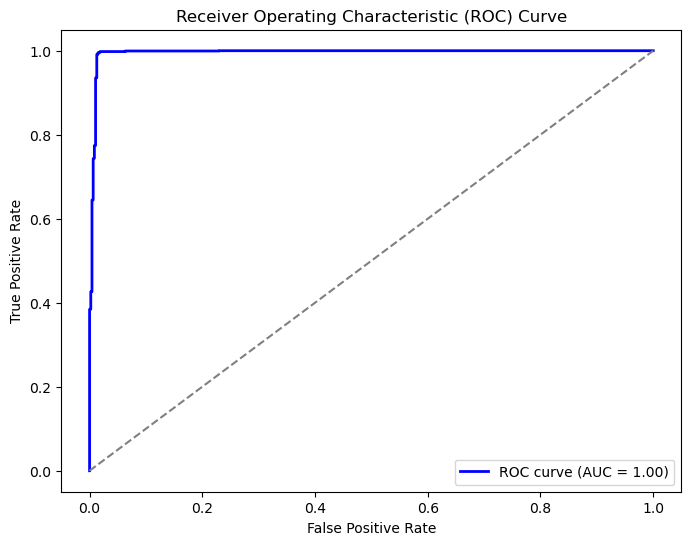

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert 'red' to 0 and 'white' to 1
wtp_test_y_numeric = label_encoder.fit_transform(wtp_test_y)

# Get predicted probabilities for positive class (label=1)
wtp_lr_probs = wtp_lr.predict_proba(wtp_test_SX)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(wtp_test_y_numeric, wtp_lr_probs)
roc_auc = roc_auc_score(wtp_test_y_numeric, wtp_lr_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Train a Model using Deep Learning (MLP)

### Encode Response class labels 

In [8]:
le = LabelEncoder()
le.fit(wtp_train_y)
# encode wine type labels
wtp_train_ey = le.transform(wtp_train_y)
wtp_test_ey = le.transform(wtp_test_y)

### Build & Compile DNN Model Architecture

In [41]:
from keras.models import Sequential
from keras.layers import Dense

wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(16, activation='relu', input_shape=(11,)))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(1, activation='sigmoid'))

wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [42]:
history = wtp_dnn_model.fit(wtp_train_SX, wtp_train_ey, epochs=10, batch_size=5, 
                            shuffle=True, validation_split=0.1, verbose=1)

Train on 4092 samples, validate on 455 samples
Epoch 1/10
4092/4092 [==============================] - 1s - loss: 0.1266 - acc: 0.9467 - val_loss: 0.0115 - val_acc: 0.9978
Epoch 2/10
4092/4092 [==============================] - 1s - loss: 0.0315 - acc: 0.9934 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3/10
4092/4092 [==============================] - 1s - loss: 0.0235 - acc: 0.9954 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4/10
4092/4092 [==============================] - 1s - loss: 0.0190 - acc: 0.9963 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 5/10
4092/4092 [==============================] - 1s - loss: 0.0169 - acc: 0.9963 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 6/10
4092/4092 [==============================] - 1s - loss: 0.0146 - acc: 0.9963 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 7/10
4092/4092 [==============================] - 1s - loss: 0.0123 - acc: 0.9973 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 8/10
4092/4092 [==============================] - 1s - loss: 0.0110 - ac

### Predict on Test dataset

In [43]:
wtp_dnn_ypred = wtp_dnn_model.predict_classes(wtp_test_SX)
wtp_dnn_predictions = le.inverse_transform(wtp_dnn_ypred) 

  32/1950 [..............................] - ETA: 1s

### Evaluate Model Performance

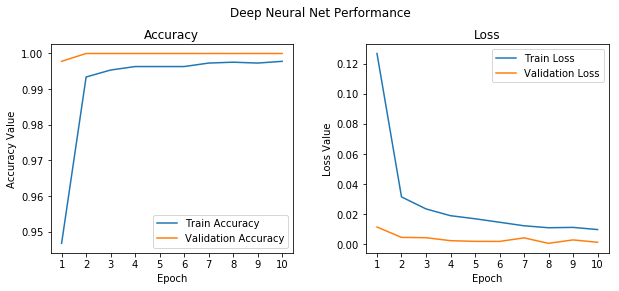

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,11))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Model Interpretation

## View Feature importances

[11/11] features ████████████████████ Time elapsed: 0 seconds

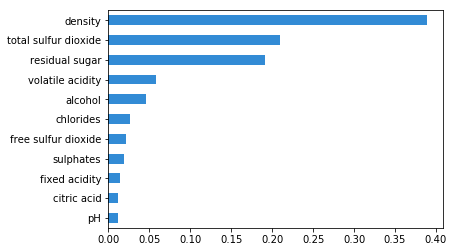

In [14]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

wtp_interpreter = Interpretation(wtp_test_SX, feature_names=wtp_features.columns)
wtp_im_model = InMemoryModel(wtp_lr.predict_proba, examples=wtp_train_SX, target_names=wtp_lr.classes_)
plots = wtp_interpreter.feature_importance.plot_feature_importance(wtp_im_model, ascending=False)

## View model ROC curve

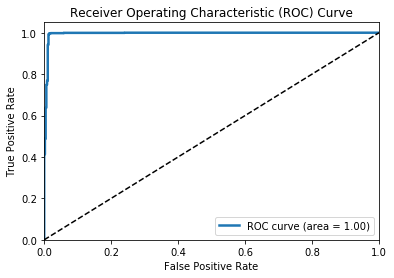

In [15]:
meu.plot_model_roc_curve(wtp_lr, wtp_test_SX, wtp_test_y)

## Visualize Model Decision Surface

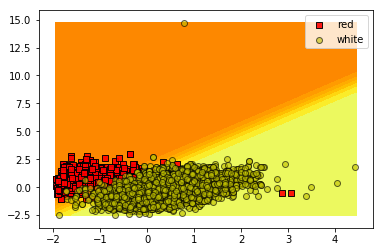

In [59]:
feature_indices = [i for i, feature in enumerate(wtp_feature_names) 
                       if feature in ['density', 'total sulfur dioxide']]
meu.plot_model_decision_surface(clf=wtp_lr, train_features=wtp_train_SX[:, feature_indices], 
                                train_labels=wtp_train_y, plot_step=0.02, cmap=plt.cm.Wistia_r,
                                markers=[',', 'o'], alphas=[0.9, 0.6], colors=['r', 'y'])

# Predicting Wine Quality

## Prepare Training and Testing datasets

In [14]:
wqp_features = wines.iloc[:,:-3]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wqp_train_y), Counter(wqp_test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 2737, 'low': 1666, 'high': 144}) Counter({'medium': 1178, 'low': 718, 'high': 54})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [15]:
wqp_test_y.shape

(1950,)

## Feature Scaling

In [16]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_train_X)

# Scale the train set
wqp_train_SX = wqp_ss.transform(wqp_train_X)

# Scale the test set
wqp_test_SX = wqp_ss.transform(wqp_test_X)

## Train, Predict & Evaluate Model using Decision Tree 

In [45]:
from sklearn.tree import DecisionTreeClassifier

wqp_dt = DecisionTreeClassifier()
wqp_dt.fit(wqp_train_SX, wqp_train_y)

wqp_dt_predictions = wqp_dt.predict(wqp_test_SX)

#meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_dt_predictions, classes=wqp_label_names)

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(wqp_test_y, wqp_dt_predictions)
cm

array([[ 16,   2,  36],
       [  5, 491, 222],
       [ 41, 225, 912]])

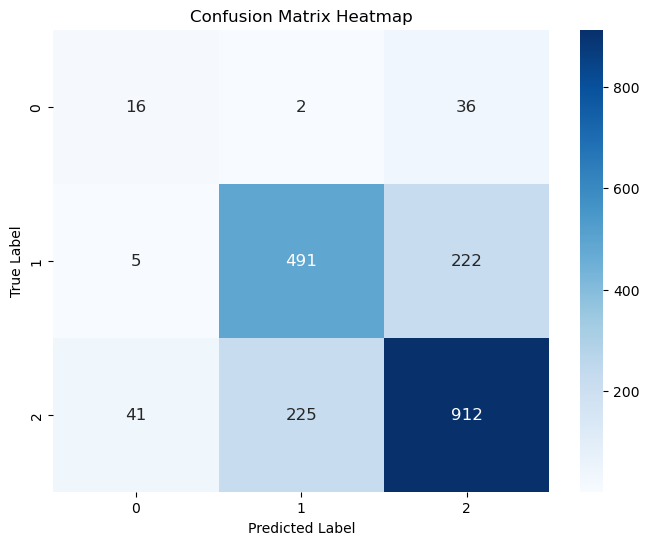

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12})

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## View Feature Importances from Decision Tree Model

In [20]:
wqp_dt_feature_importances = wqp_dt.feature_importances_
wqp_dt_feature_importances

array([0.06518355, 0.11253506, 0.07639559, 0.07381694, 0.07898102,
       0.06752277, 0.09700797, 0.08229356, 0.07258473, 0.07793909,
       0.19573972])

In [21]:
zip1 = zip(wqp_feature_names,wqp_dt_feature_importances)
list(zip1)

[('fixed acidity', 0.06518355424741595),
 ('volatile acidity', 0.11253506378310442),
 ('citric acid', 0.07639558641434337),
 ('residual sugar', 0.07381693618539421),
 ('chlorides', 0.07898102061060898),
 ('free sulfur dioxide', 0.06752277385059693),
 ('total sulfur dioxide', 0.09700796758504666),
 ('density', 0.08229355729034843),
 ('pH', 0.07258473128337091),
 ('sulphates', 0.07793909089225405),
 ('alcohol', 0.1957397178575162)]

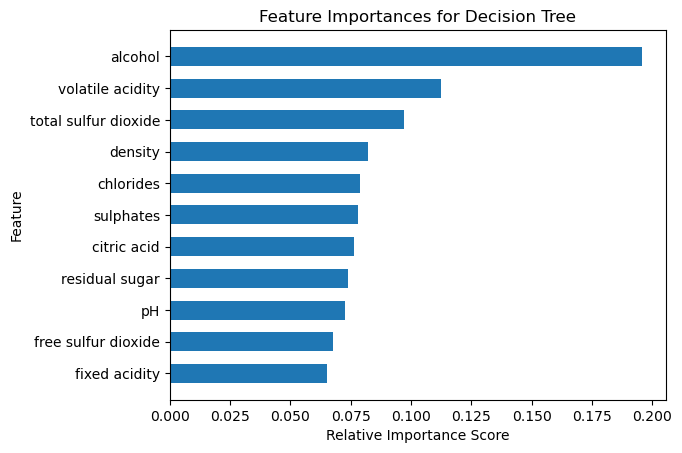

In [22]:
zip1 = zip(wqp_feature_names, wqp_dt_feature_importances)
wqp_dt_feature_names, wqp_dt_feature_scores = zip(*sorted(zip1, key=lambda x: x[1]))
y_position = list(range(len(wqp_dt_feature_names)))
plt.barh(y_position, wqp_dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position , wqp_dt_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

## Visualize the Decision Tree

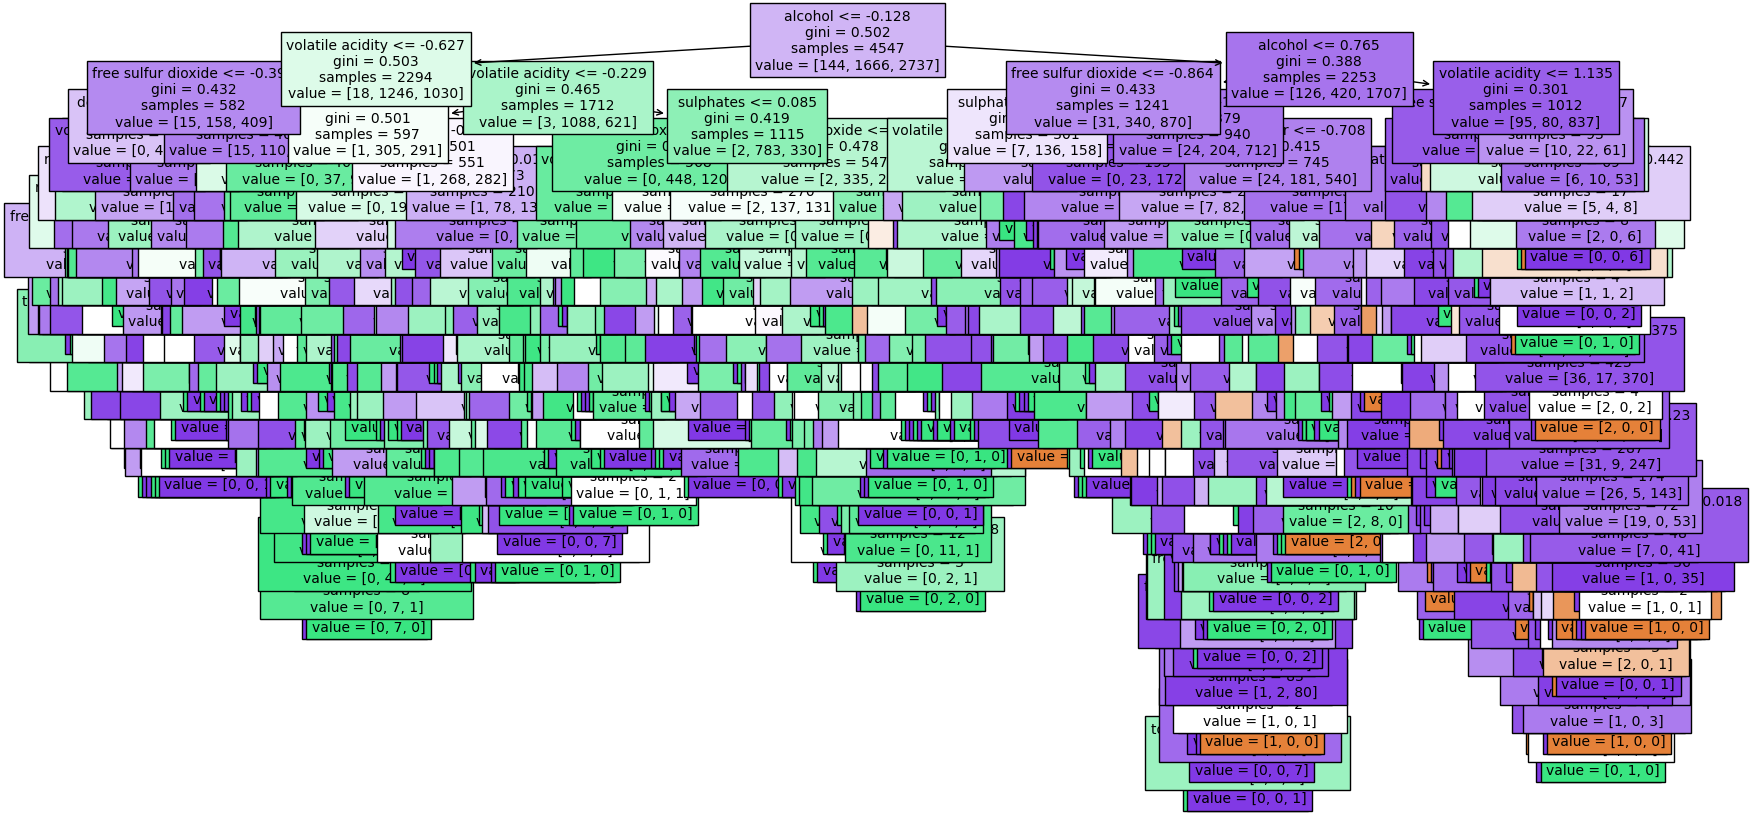

In [33]:
# from graphviz import Source
# from sklearn import tree
# from IPython.display import Image



# # Image(png_data)

# from sklearn.tree import export_graphviz
# import graphviz

# dot_data = export_graphviz(wqp_dt, out_file=None, 
#                            feature_names=wqp_feature_names,
#                            filled=True, rounded=True, special_characters=True)

# graph = graphviz.Source(dot_data)
# graph.render('wqp_decision_tree', view=True)  
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(wqp_dt, feature_names=wqp_feature_names,filled=True,  fontsize=10)
plt.show()

## Train, Predict & Evaluate Model using Random Forests

In [34]:
from sklearn.ensemble import RandomForestClassifier
# train the model
wqp_rf = RandomForestClassifier()
wqp_rf.fit(wqp_train_SX, wqp_train_y)
# predict and evaluate performance
wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
# meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, classes=wqp_label_names)

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(wqp_test_y, wqp_rf_predictions)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(wqp_test_y, wqp_rf_predictions)
print("Accuracy:", accuracy)

Confusion Matrix:
[[  15    2   37]
 [   0  513  205]
 [   0  130 1048]]
Accuracy: 0.8082051282051282


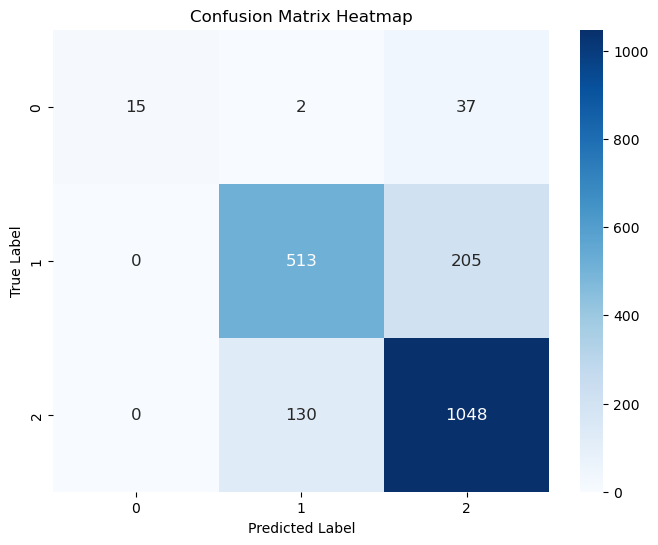

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Hyperparameter tuning with Grid Search & Cross Validation

In [38]:
print(wqp_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Get the best hyperparameter values

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                'n_estimators': [50, 100, 200], 
                'max_features': ['sqrt', 'log2']    
              }

wqp_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5,
                       scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'max_features': 'sqrt', 'n_estimators': 100}


### View grid search results

In [40]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_features': 'sqrt', 'n_estimators': 50} 0.7873 0.0106
{'max_features': 'sqrt', 'n_estimators': 100} 0.7898 0.0088
{'max_features': 'sqrt', 'n_estimators': 200} 0.7865 0.0085
{'max_features': 'log2', 'n_estimators': 50} 0.7873 0.0106
{'max_features': 'log2', 'n_estimators': 100} 0.7898 0.0088
{'max_features': 'log2', 'n_estimators': 200} 0.7865 0.0085


### Train, Predict & Evaluate Random Forest Model with tuned hyperparameters

In [41]:
wqp_rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
wqp_rf.fit(wqp_train_SX, wqp_train_y)

wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
#meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, classes=wqp_label_names)

## Train, Predict & Evaluate Model using Extreme Gradient Boosting

### Load and set dependencies

In [43]:


import xgboost as xgb

### Train the model

In [42]:
wqp_train_y

array(['medium', 'low', 'low', ..., 'medium', 'medium', 'medium'],
      dtype=object)

In [44]:
wqp_xgb_model = xgb.XGBClassifier(seed=42)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['high' 'low' 'medium']

### Predict and Evaluate Model 

In [29]:
wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7446
Precision: 0.7443
Recall: 0.7446
F1 Score: 0.7344

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.71      0.64      0.67       718
     medium       0.76      0.84      0.80      1178
       high       0.83      0.09      0.17        54

avg / total       0.74      0.74      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           456    261    1
        medium        187    991    0
        high            1     48    5


### Get the best hyperparameter values

In [30]:
param_grid = {
                'n_estimators': [100, 200, 300], 
                'max_depth': [5, 10, 15],
                'learning_rate': [0.3, 0.5]
              }

wqp_clf = GridSearchCV(xgb.XGBClassifier(tree_method='exact', seed=42), param_grid, 
                       cv=5, scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}


### View grid search results

In [31]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100} 0.7779 0.0118
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200} 0.7799 0.0066
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300} 0.7788 0.0091
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100} 0.7871 0.0048
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200} 0.7851 0.0048
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300} 0.7803 0.0027
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100} 0.7823 0.0107
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 200} 0.7818 0.0105
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 300} 0.7805 0.0112
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100} 0.7781 0.0123
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200} 0.7735 0.0091
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300} 0.7748 0.0078
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100} 0.7774 0.0096
{'learning_rate': 0.5, 'max_dep

### Train, Predict & Evaluate Extreme Gradient Boosted Model with tuned hyperparameters

In [32]:
wqp_xgb_model = xgb.XGBClassifier(seed=42, max_depth=10, learning_rate=0.3, n_estimators=100)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7887
Precision: 0.7891
Recall: 0.7887
F1 Score: 0.7841

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.75      0.71      0.73       718
     medium       0.81      0.86      0.83      1178
       high       0.89      0.30      0.44        54

avg / total       0.79      0.79      0.78      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           511    207    0
        medium        165   1011    2
        high            3     35   16


# Model Interpretation

## Comparative analysis of Model Feature importances

[11/11] features ████████████████████ Time elapsed: 0 seconds

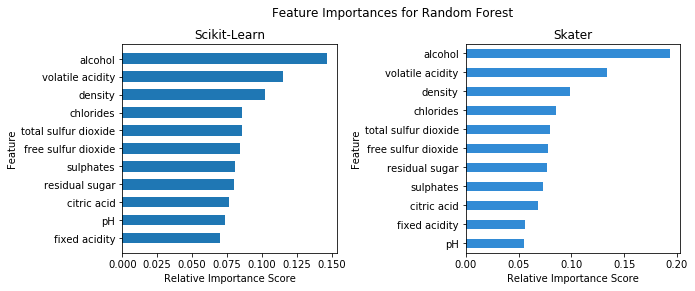

In [33]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
# leveraging skater for feature importances
interpreter = Interpretation(wqp_test_SX, feature_names=wqp_feature_names)
wqp_im_model = InMemoryModel(wqp_rf.predict_proba, examples=wqp_train_SX, target_names=wqp_rf.classes_)
# retrieving feature importances from the scikit-learn estimator
wqp_rf_feature_importances = wqp_rf.feature_importances_
wqp_rf_feature_names, wqp_rf_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_rf_feature_importances), 
                                                          key=lambda x: x[1]))
# plot the feature importance plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Feature Importances for Random Forest', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.6)
y_position = list(range(len(wqp_rf_feature_names)))
ax1.barh(y_position, wqp_rf_feature_scores, height=0.6, align='center', tick_label=wqp_rf_feature_names)
ax1.set_title("Scikit-Learn")
ax1.set_xlabel('Relative Importance Score')
ax1.set_ylabel('Feature')
plots = interpreter.feature_importance.plot_feature_importance(wqp_im_model, ascending=False, ax=ax2)
ax2.set_title("Skater")
ax2.set_xlabel('Relative Importance Score')
ax2.set_ylabel('Feature')

## View Model ROC Curve

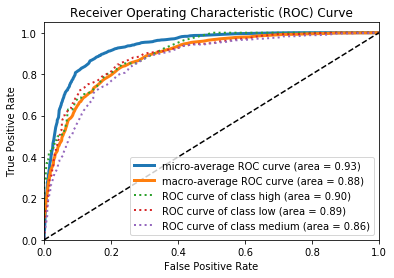

In [34]:
meu.plot_model_roc_curve(wqp_rf, wqp_test_SX, wqp_test_y)

## Visualize Model decision surface

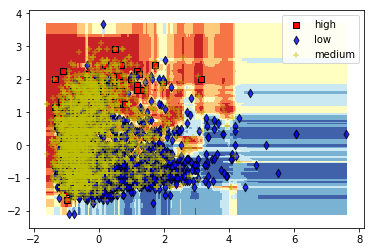

In [35]:
feature_indices = [i for i, feature in enumerate(wqp_feature_names) 
                       if feature in ['alcohol', 'volatile acidity']]
meu.plot_model_decision_surface(clf=wqp_rf, train_features=wqp_train_SX[:, feature_indices], 
                      train_labels=wqp_train_y, plot_step=0.02, cmap=plt.cm.RdYlBu,
                      markers=[',', 'd', '+'], alphas=[1.0, 0.8, 0.5], colors=['r', 'b', 'y'])

## Interpreting Model Predictions

In [36]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(wqp_train_SX, feature_names=wqp_feature_names, 
                           discretize_continuous=True, 
                           class_names=wqp_rf.classes_)

In [80]:
exp.explain_instance(wqp_test_SX[10], wqp_rf.predict_proba, top_labels=1).show_in_notebook() 

In [81]:
exp.explain_instance(wqp_test_SX[747], wqp_rf.predict_proba, top_labels=1).show_in_notebook() 

## Visualizing partial dependencies

[81/81] grid cells ████████████████████ Time elapsed: 8 seconds

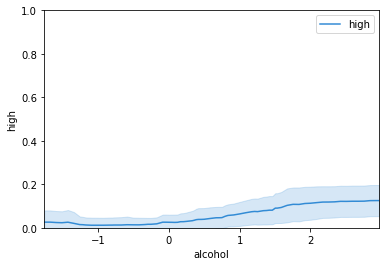

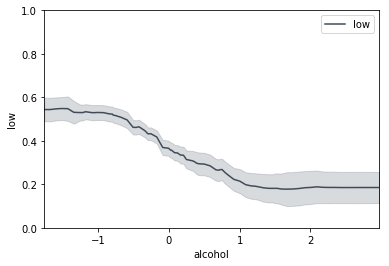

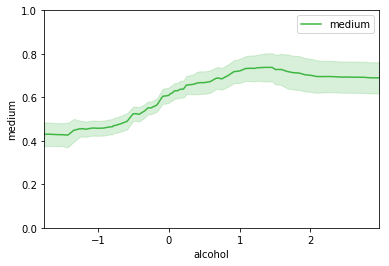

In [39]:
axes_list = interpreter.partial_dependence.plot_partial_dependence(['alcohol'], wqp_im_model, 
                                                                   grid_resolution=100, 
                                                                   with_variance=True,
                                                                   figsize = (6, 4))
axs = axes_list[0][3:]
[ax.set_ylim(0, 1) for ax in axs];

[4698/4698] grid cells ████████████████████ Time elapsed: 129 seconds

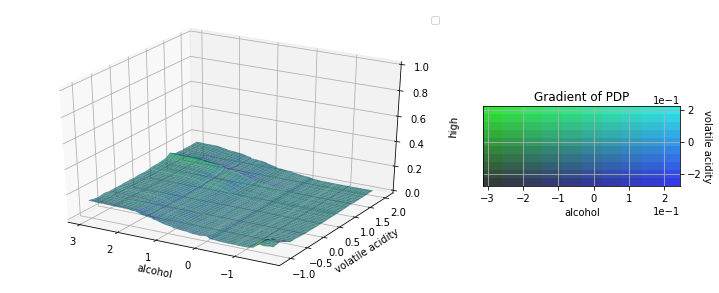

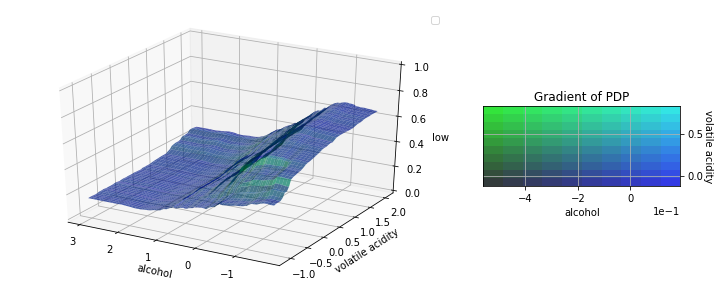

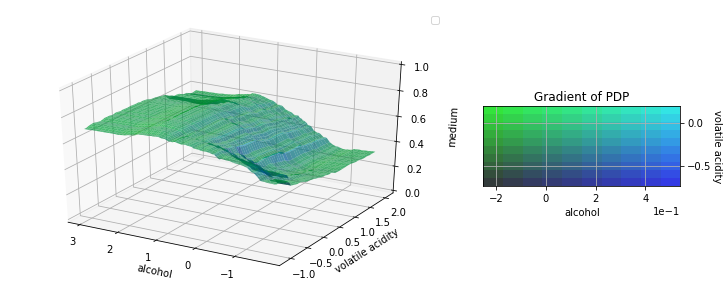

In [40]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('alcohol', 'volatile acidity')], 
                                                                    wqp_im_model, n_samples=1000, figsize=(12, 5),
                                                                    grid_resolution=100)
axs = plots_list[0][3:]
[ax.set_zlim(0, 1) for ax in axs];